In [2]:
!pip install keras_core
!pip install keras_nlp


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 950.8/950.8 kB 10.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 571.8/571.8 kB 7.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 28.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 590.6/590.6 MB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.3/5.3 MB 86.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 91.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 94.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 65.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 347.7/347.7 kB 27.9 MB/s eta 0:00:00
  Attempting uninstall: ml-dtypes
    Found existing installation: ml-dtypes 0.2.0
    Uninstalling ml-dtypes-0.2.0:
      Successfully uninstalled ml-dtypes-0.2.0
  Attempting uninstall: h5py
    Found existing installation: h5py 3.9.0
    Uninstalling h5py-3.9.0:
      Suc

In [5]:
import os
os.environ['KERAS_BACKEND'] = 'tensorflow'
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import tensorflow as tf
#import keras_core as keras
#import keras_nlp

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, History
from tensorflow.keras.regularizers import l2

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,classification_report, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
import matplotlib.pyplot as plt


print("TensorFlow version:", tf.__version__)


TensorFlow version: 2.16.2


# Fake and Real News Classification Problem

## Problem Description:

<span style="font-size:1.1em;">  The goal is to be able to classify wether or not a particular new item is real or fake.</span>


<span style="font-size:1.1em;"> Lets first load the data and explore it </span>


In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
%cd /content/drive/My Drive/fake_news/

/content/drive/My Drive/fake_news


In [8]:
real_news_data = pd.read_csv("True.csv")[['text']]
fake_news_data = pd.read_csv("Fake.csv")[['text']]



print('real_news_data Set Shape = {}'.format(real_news_data.shape))
print('fake_news_data Set Shape = {}'.format(fake_news_data.shape))

real_news_data Set Shape = (21417, 1)
fake_news_data Set Shape = (23481, 1)


In [9]:
real_news_data['target'] = 1
fake_news_data['target'] = 0

In [10]:

real_news_data.head()


,text,target
0,WASHINGTON (Reuters) - The head of a conservat...,1
1,WASHINGTON (Reuters) - Transgender people will...,1
2,WASHINGTON (Reuters) - The special counsel inv...,1
3,WASHINGTON (Reuters) - Trump campaign adviser ...,1
4,SEATTLE/WASHINGTON (Reuters) - President Donal...,1


In [11]:
fake_news_data.head()

,text,target
0,Donald Trump just couldn t wish all Americans ...,0
1,House Intelligence Committee Chairman Devin Nu...,0
2,"On Friday, it was revealed that former Milwauk...",0
3,"On Christmas day, Donald Trump announced that ...",0
4,Pope Francis used his annual Christmas Day mes...,0


In [12]:
df = pd.concat([fake_news_data,real_news_data]).sample(frac=1).reset_index(drop=True)

In [13]:
df

,text,target
0,WASHINGTON (Reuters) - U.S. House Republicans ...,1
1,The Trump presidential campaign has already fa...,0
2,21st Century Wire says This latest diplomatic ...,0
3,DUBLIN/LONDON (Reuters) - Ireland and Britain ...,1
4,The video Hillary and the Left will not want A...,0
...,...,...
44893,MEXICO CITY (Reuters) - Mexican leftist presid...,1
44894,How many of these punks treating police office...,0
44895,"Just before the gunman began shooting, the Las...",0
44896,WASHINGTON (Reuters) - Former and current empl...,1


Lets actually read a few of these news articles from each category


Real News:


In [14]:
print(real_news_data['text'][0])
print(real_news_data['text'][1])
print(real_news_data['text'][2])

WASHINGTON (Reuters) - The head of a conservative Republican faction in the U.S. Congress, who voted this month for a huge expansion of the national debt to pay for tax cuts, called himself a “fiscal conservative” on Sunday and urged budget restraint in 2018. In keeping with a sharp pivot under way among Republicans, U.S. Representative Mark Meadows, speaking on CBS’ “Face the Nation,” drew a hard line on federal spending, which lawmakers are bracing to do battle over in January. When they return from the holidays on Wednesday, lawmakers will begin trying to pass a federal budget in a fight likely to be linked to other issues, such as immigration policy, even as the November congressional election campaigns approach in which Republicans will seek to keep control of Congress. President Donald Trump and his Republicans want a big budget increase in military spending, while Democrats also want proportional increases for non-defense “discretionary” spending on programs that support educati

Fake News:

In [15]:
print(fake_news_data['text'][0])
print(fake_news_data['text'][1])
print(fake_news_data['text'][2])

Donald Trump just couldn t wish all Americans a Happy New Year and leave it at that. Instead, he had to give a shout out to his enemies, haters and  the very dishonest fake news media.  The former reality show star had just one job to do and he couldn t do it. As our Country rapidly grows stronger and smarter, I want to wish all of my friends, supporters, enemies, haters, and even the very dishonest Fake News Media, a Happy and Healthy New Year,  President Angry Pants tweeted.  2018 will be a great year for America! As our Country rapidly grows stronger and smarter, I want to wish all of my friends, supporters, enemies, haters, and even the very dishonest Fake News Media, a Happy and Healthy New Year. 2018 will be a great year for America!  Donald J. Trump (@realDonaldTrump) December 31, 2017Trump s tweet went down about as welll as you d expect.What kind of president sends a New Year s greeting like this despicable, petty, infantile gibberish? Only Trump! His lack of decency won t eve

# EDA

Lets look at the target dist

Text(0.5, 1.0, 'Target Dist.')

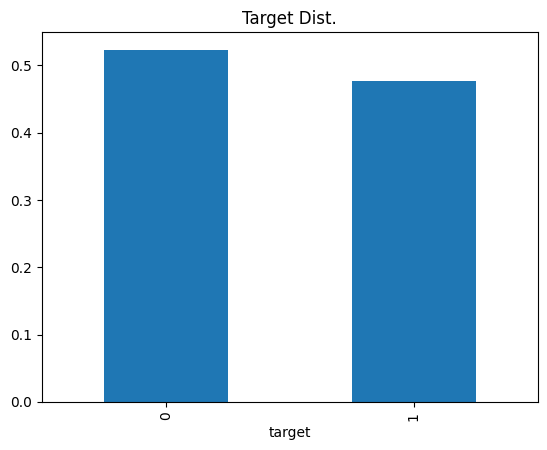

In [16]:
df.target.value_counts(normalize=True).plot(kind='bar')
plt.title('Target Dist.')

Drop duplicates

In [17]:
print(df.duplicated().sum())
df = df.drop_duplicates()
print(df.duplicated().sum())

6251
0


Check for NaN

In [18]:
df.isna().sum()

text      0
target    0
dtype: int64

Lets look at the distribution of lengths of the different news articles.

In [19]:
df["length"] = df["text"].apply(lambda x : len(x))


<ipython-input-19-5a1bbd199391>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["length"] = df["text"].apply(lambda x : len(x))


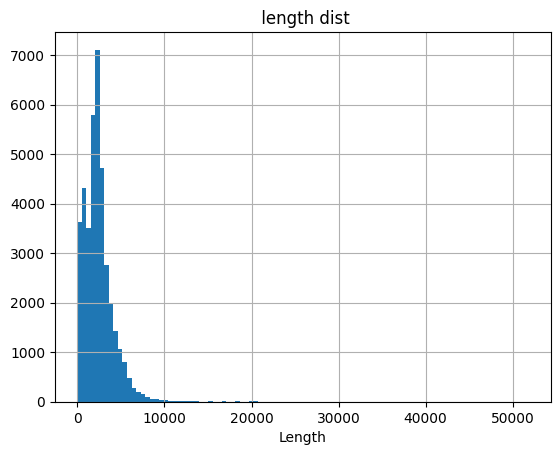

Stat
count    38647.000000
mean      2455.824540
std       1936.624786
min          1.000000
25%       1318.000000
50%       2227.000000
75%       3096.000000
max      51794.000000
Name: length, dtype: float64


In [20]:
df["length"].hist(bins=100)
plt.xlabel("Length")
plt.title(" length dist")
plt.show()
print("Stat")
print(df["length"].describe())

We can see that text length of about 10000 captures the majority of the data without including the long tail.

So we can see some of news items are fairly long. Much longer than the tweets we used in the NLP assignment where we used max length of 160.
This means we will need to choose an architecture that can have  both short and long term memory to handle this kind of data

# Model Architecture



To deal with the large variation in length of text we chose to use the LSTM architecture here. LSTM stands for Long/SHort Term Memory. It is a type of Recurrent Neural Network (RNN) but unlike the Vanilla RNN it includes the concept of "gates" and a second hidden state which captures long term memory. These features help avoid vanishing and/or exploding gradient problems in long inputs.

Lets dive deeper into the LSTM cell and see what is inside it referring to the figure below:


First lets call attention to the fact that this RNN has two hidden states h(t) is the normal hidden state any RNN has but we now add c(t) which is the hidden state which is capturing the long term memory.
The first gate is the F gate also known as the "Forget Gate" and its in charge of determining how much information our long term input should "forget". Mathematically it takes a weighted combination of the current input X(t) and the previous hidden state h(t-1), passes it through a non-linear activation function such as sigmoid and multiplies the result with the previous value of the long term memory c(t-1). Consequently, if the result of the activation function is close to 1 it means we retain most of the long term memory c(t-1), if its close to 0 it means we forget most of it.

The next two gates the I and G gates are responsible for determining how much of the current input and state should affect the long term memory. The I gate determines "how much" while the G gate determines the sign, as in wether we are adding or subtracting the output of I gate from the long term memory. Mathematically this can be implemented by taking a weighted combination of current input X(t) and previous hidden state h(t-1) and passing through a sigmoid activation function to determine the I gate output (sigmoid gives a value between 0 and 1) and then taking a weighted combination of X(t) and h(t-1) and passing them through a tanh activation function to determine the sign (tanh gives a value between -1 and 1 usually close to either one)


Finally we have to determine The current output h(t). To do this we take again a weighted combination of the current input X(t) and previous hidden state h(t-1) and pass them through sigmoid activation function to form the output gate. The final output h(t) is calculated by combining the output of the output gate and the current value of the long term memory c(t) passed through a tanh function.

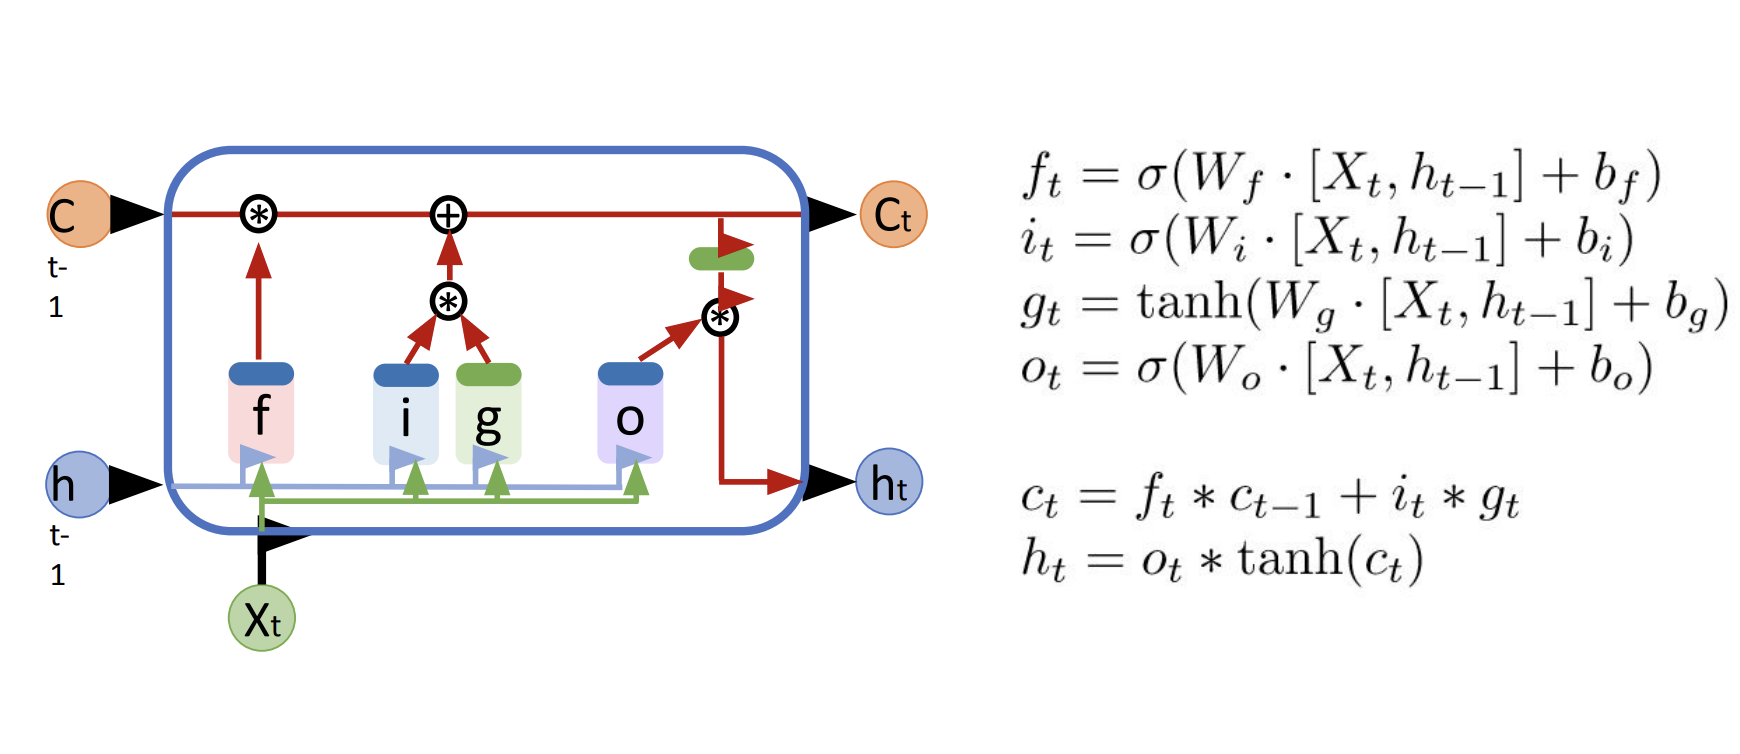

# Model Training

Lets split the data into a training and test set.

In [21]:
X = df['text']
y = df['target']

In [22]:


X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)
X_train.shape,X_test.shape,y_train.shape,y_test.shape

((30917,), (7730,), (30917,), (7730,))

Lets pre-process the text data by tokenizing the text. We will also pad the resulting token sequences to the max length we want to consider which is 10,000 per our EDA

In [23]:

# Text preprocessing
max_words = 10000
max_len = 500

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

X_train_pad = pad_sequences(X_train_seq, maxlen=max_len)
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len)


We wil now build our LSTM model using Keras sequential layers. We have an embedding layer followed by LSTM layer and finally a dense layer with sigmoid activation function to do the classification with output 0-1 reflecting the probability of input. being 0 (fake) or 1 (true)

In [24]:

# Build LSTM model
model = Sequential()
model.add(Embedding(max_words, 128, input_length=max_len))
model.add(LSTM(64, dropout=0.5, recurrent_dropout=0.5, kernel_regularizer=l2(0.01)))
model.add(Dense(1, activation='sigmoid', kernel_regularizer=l2(0.01)))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [28]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ (None, 500, 128)            │       1,280,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 64)                  │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,988,421 (15.21 MB)

 Trainable params: 1,329,473 (5.07 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2,658,948 (10.14 MB)

Finally we start the training. We will run for 5 ephochs but keep the weights from the best validation loss epoch

In [25]:

# Train model
history = History()
early_stopping = EarlyStopping(monitor='val_loss', patience=3, verbose=1, restore_best_weights=True)

model.fit(X_train_pad, y_train, epochs=5, batch_size=128, validation_split=0.2, callbacks=[history, early_stopping])

Epoch 1/5
194/194 ━━━━━━━━━━━━━━━━━━━━ 221s 1s/step - accuracy: 0.8401 - loss: 1.2117 - val_accuracy: 0.9678 - val_loss: 0.1769
Epoch 2/5
194/194 ━━━━━━━━━━━━━━━━━━━━ 218s 900ms/step - accuracy: 0.9681 - loss: 0.1827 - val_accuracy: 0.9728 - val_loss: 0.1421
Epoch 3/5
194/194 ━━━━━━━━━━━━━━━━━━━━ 201s 896ms/step - accuracy: 0.9741 - loss: 0.1523 - val_accuracy: 0.9651 - val_loss: 0.2086
Epoch 4/5
194/194 ━━━━━━━━━━━━━━━━━━━━ 175s 902ms/step - accuracy: 0.9794 - loss: 0.1675 - val_accuracy: 0.9694 - val_loss: 0.1783
Epoch 5/5
194/194 ━━━━━━━━━━━━━━━━━━━━ 202s 900ms/step - accuracy: 0.9823 - loss: 0.1424 - val_accuracy: 0.9764 - val_loss: 0.1387
Restoring model weights from the end of the best epoch: 5.


We have obtained a model with good accuracy. Lets use to make predictions. Note that we have to ultimately convert the output of the model which can be interpreted as Prob("1") to a strictly 0 or 1 output

In [26]:
# Predict
y_pred_prob = model.predict(X_test_pad)
y_pred = (y_pred_prob > 0.5).astype("int32")



242/242 ━━━━━━━━━━━━━━━━━━━━ 65s 267ms/step


Finally lets plot some training and validation loss and precision and recall scores. We see that validation accuracy peaks at epoch 3.

Accuracy: 0.9807244501940492
Precision: 0.9783847980997624
Recall: 0.9861144361982284
F1 Score: 0.982234410397043


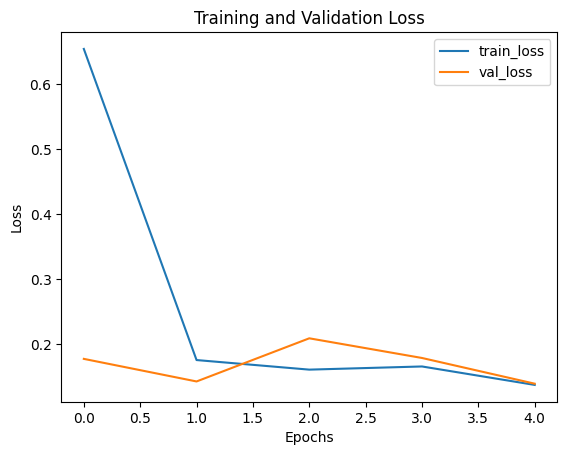

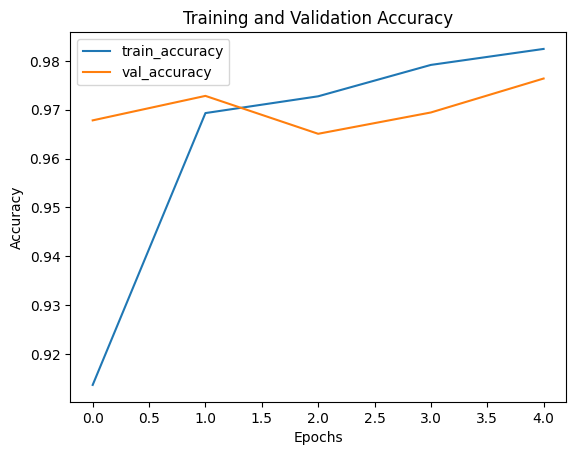

In [27]:


# Compute evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')

# Plot training and validation loss
plt.figure()
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.figure()
plt.plot(history.history['accuracy'], label='train_accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

Since trainign took quite a while lets save the weights for later use.

In [32]:
# Save the weights
model.save_weights('./my_checkpoint.weights.h5')



# Conclusion

The text classification problem we faced included a text corpus with large variation on the length or number of words. We found that using LSTM (Long/Short Term Memory) Recurrent Neural network was a good solution to the problem. With a fairly small model with only 1.3M trainable parameters we were able to achieve validation set accuracy of about 97%